# SAGACITE (Statistical and Geometric Analysis of CITE-seq)


This notebook contains two examples of applying geometric and statistical methods to analyze preprocessed cell-surface protein count data from CITE-seq.

We import the python functions from `/code/geom_stat_funs.py`, which implement the methods described in our manuscript:

> Riemannian geometry and statistical modeling correct for batch effects and control false discoveries in single-cell surface protein count data from CITE-seq (2020), [available on bioRxiv](https://doi.org/10.1101/2020.04.28.067306).

In [1]:
import os
import re
import time
# import gzip
# import h5py
import numpy as np
# import scipy.io
# import scipy.sparse
import scipy.stats
import scipy.special
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
import seaborn as sns

## import functions from geom_stat_funs.py in the same folder
from geom_stat_funs import * 

## First example: human CBMC data set with 'spike-in' mouse cells


First, we apply the methods to analyze the UMI (unique molecular identifier) count of ADTs (antibody-derived tags) in [the public dataset of human CBMC](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE100866) (cord blood mononuclear cells), which comes from a single experiment and contains spiked in mouse cells as the 'noise' model. The unprocessed data can be downloaded as `GSE100866_CBMC_8K_13AB_10X-ADT_umi.csv.gz` under [GSE100866](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE100866).


The single-cell ADT count data is complementary to the single-cell RNA-seq (scRNA-seq) count data ( `GSE100866_CBMC_8K_13AB_10X-RNA_umi.csv.gz` under [GSE100866](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE100866) ), which is available from the same CITE-seq experiment. To preprocess the RNA data, we have followed the suggested procedures of normalization, feature selection, dimensional reduction, and Louvain clustering in [Seurat v3](https://satijalab.org/seurat/v3.1/multimodal_vignette.html "Using Seurat with multi-modal data"). We have selected the cells classified as mouse (with mouse RNA percentage >95%), as well as the eight human cell types: B cells, memory CD4+ T cells, naive CD4+ T cells, CD8+ T cells, natural killer (NK) cells, dendritic cells (DCs), CD34+ cells and erythrocytes, via [finding the RNA biomarkers for each cluster](https://satijalab.org/seurat/v3.1/pbmc3k_tutorial.html "Seurat - Guided Clustering Tutorial"). With the information from the scRNA-seq data, we have filtered the single-cell ADT count data, and labeled each cell with a 'transcriptomic label', which is stored in `/data/human_CBMC_ADT_raw_w_label.csv`.

In [2]:
path_data = os.path.join( '..', 'data')
path_csv = os.path.join( path_data, 'human_CBMC_ADT_raw_w_label.csv')
df_ADT_raw_w_label = pd.read_csv(path_csv, index_col=0)
df_ADT_label = df_ADT_raw_w_label['transcriptomic_label']
df_ADT_raw = df_ADT_raw_w_label.drop(columns=['transcriptomic_label'])
list_idents_all = np.unique(df_ADT_label)
list_antigens_all = np.asarray(df_ADT_raw.columns)

path_outs = os.path.join( '..', 'output')
if not os.path.exists(path_outs):
    os.makedirs(path_outs)
path_figs = path_outs
# path_figs = os.path.join( path_outs, 'figs' )
# if not os.path.exists(path_figs):
#     os.makedirs(path_figs)
# # uncomment to choose a different folder for figures

We read the filtered and labeled data, and proceed to the analysis. Unless otherwise modified, output of the analysis, including figures, will be stored in the folder `/output`.


The raw count data with the transcriptomic labels is loaded in the Pandas DataFrame `df_ADT_raw_w_label`.

In [3]:
df_ADT_raw_w_label

,CD3,CD4,CD8,CD45RA,CD56,CD16,CD10,CD11c,CD14,CD19,CD34,CCR5,CCR7,transcriptomic_label
CTGTTTACACCGCTAG,60,72,76,575,64,161,156,77,206,70,179,99,104,MOUSE
CTCTACGGTGTGGCTC,52,49,59,3943,68,107,95,65,129,665,79,101,72,MOUSE
AGCAGCCAGGCTCATT,89,112,61,682,87,117,113,65,169,79,78,85,80,MOUSE
GAATAAGAGATCCCAT,55,66,56,378,58,82,66,44,136,49,83,60,46,MOUSE
GTGCATAGTCATGCAT,63,80,94,644,104,168,129,92,164,81,152,110,89,MOUSE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GGGAATGCAGTCAGCC,38,46,47,217,72,64,90,32,67,38,49,55,65,Erythrocyte
TCGCGAGCAAGGACAC,25,26,44,213,14,49,45,27,41,21,41,29,27,Erythrocyte
CCCATACAGTCTCGGC,10,22,21,126,32,28,41,18,27,10,18,29,16,Erythrocyte
TGGTTCCGTCAAAGAT,536,389,418,822,697,308,417,584,600,402,456,451,281,Erythrocyte


### Mapping cells to a manifold and computing Riemannian mean


Given a list of selected antigens, for each subset of cells with a distinct label (or possibly for a union of multiple subsets), we can transform the count data to proportional data residing on the probability simplex, and (via a diffeomorphism $\psi$) map them to a hypersphere of radius 2, a manifold with the Fisher information metric inherited from the open probability simplex. We can then compute the Riemannian mean (commonly known as [Fréchet mean](https://en.wikipedia.org/wiki/Fr%C3%A9chet_mean)) on the manifold. The points on the hypersphere can be mapped back to the probability simplex (via the inverse map $\psi^{-1}$).


Take the B cells as an example. We can map the data points to the hypersphere and compute the Riemannian mean (they can be easily mapped back to the simplex).

In [4]:
# choose a list of antigens
list_antigens_select = ['CD3','CD19','CD56']

label = 'B' # choose a subset of cells
df_ADT_subset = df_ADT_raw.loc[df_ADT_label == label]
count_data = df_ADT_subset[list_antigens_select].copy()

df_ADT_on_hsphere = pd.DataFrame(count2shpere(count_data), 
                                 columns=list_antigens_select)
df_ADT_on_simplex = psi_inv(df_ADT_on_hsphere)

rm_on_hsphere = count2shpere_CoM(count_data)
rm_on_simplex = psi_inv(rm_on_hsphere)

We can apply the mapping and the Riemannian mean calculation to all the subsets of cells. When the list contains three antigens, for example {CD3, CD19, CD56} in this case, mapping to the sphere in three dimension is suitable for a visualization of the data. 

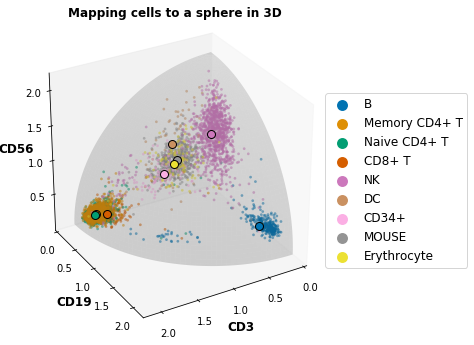

In [5]:
from mpl_toolkits.mplot3d import Axes3D

## choose a list of antigens
list_antigens_select = ['CD3','CD19','CD56']
lx, ly, lz = list_antigens_select

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
## ax.set_aspect("equal")
ax.grid(False)
ax.set_xlim3d(0, 2.2)
ax.set_ylim3d(0,2.2)
ax.set_zlim3d(0,2.2)
ax.view_init(30, 60)

u, v = np.mgrid[0:0.5*np.pi:200j, 0:0.5*np.pi:100j]
x = np.cos(u)*np.sin(v) *2.
y = np.sin(u)*np.sin(v) *2.
z = np.cos(v) *2.
ax.plot_surface(x, y, z, color="gray", alpha=0.2)

list_idents0 = ['B', 'Memory CD4+ T', 'Naive CD4+ T', 'CD8+ T', 
                'NK', 'DC', 'CD34+', 'MOUSE', 'Erythrocyte' ]
n_i = len(list_idents0)
colors = sns.color_palette("colorblind", n_i)

for i in range(n_i):
    ident = list_idents0[i]
    df_ADT_subset = df_ADT_raw.loc[df_ADT_label == ident]
    count_data = df_ADT_subset[list_antigens_select].copy()
    rf_3 = count2shpere(count_data)
    rx = rf_3[:,0]
    ry = rf_3[:,1]
    rz = rf_3[:,2]
    ax.scatter(rx,ry,rz, s=30, color=colors[i], alpha=0.5, marker='.', 
               linewidths=0, label=ident )
    rf_3m = count2shpere_CoM(count_data)
    ax.plot([rf_3m[0]], [rf_3m[1]], [rf_3m[2]], 'o', color=colors[i], 
             markersize=8, markeredgecolor='black', zorder=100)

ax.set_xlabel(lx, weight='bold', fontsize='large')
ax.set_ylabel(ly, weight='bold', fontsize='large')
ax.set_zlabel(lz, weight='bold', fontsize='large')
ax.set_title('Mapping cells to a sphere in 3D\n', weight='bold', 
             fontsize='large')
ax.set_xticks([0., 0.5, 1., 1.5, 2.])
ax.set_yticks([0., 0.5, 1., 1.5, 2.])
ax.set_zticks([0.5, 1., 1.5, 2.])

leg = plt.legend(bbox_to_anchor=(0.95, 0.75), loc=2, borderaxespad=0., 
                 fontsize='large', markerscale=4)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.show()
fig.savefig(path_figs+os.sep+'Mapping_'+'human_CBMC'+lx+'_vs_'+ly+'_vs_'+lz+'.pdf', bbox_inches='tight')


We can also use a longer list of antigens, or the entire list of antigens. In this case, the visualization of the data points in high dimensions is not possible, but we can show the components of the Riemannian mean of each subset of cells in a bar plot.

In [6]:
# use the entire list of antigens
list_antigens_select = list_antigens_all

label = 'B' # choose a subset of cells
df_ADT_subset = df_ADT_raw.loc[df_ADT_label == label]
count_data = df_ADT_subset[list_antigens_select].copy()

df_ADT_on_hsphere = pd.DataFrame(count2shpere(count_data), 
                                 columns=list_antigens_select)
df_ADT_on_simplex = psi_inv(df_ADT_on_hsphere)

rm_on_hsphere = count2shpere_CoM(count_data)
rm_on_simplex = psi(rm_on_hsphere)

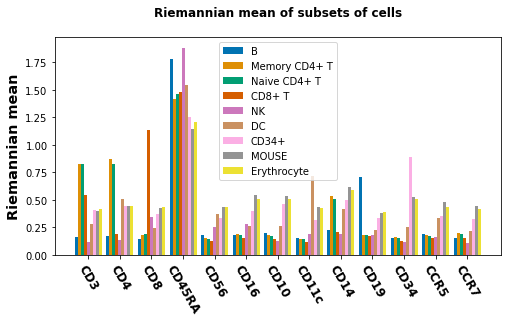

In [7]:
list_idents0 = ['B', 'Memory CD4+ T', 'Naive CD4+ T', 'CD8+ T', 
                'NK', 'DC', 'CD34+', 'MOUSE', 'Erythrocyte' ]
n_i = len(list_idents0)
colors = sns.color_palette("colorblind", n_i)

list_antigens_select = list_antigens_all
n_d = len(list_antigens_select)

fig = plt.figure(figsize=(8,4))
fig.add_subplot(111)

width = 0.95 / (n_i + 1)

for i in range(n_i):
    ident = list_idents0[i]
    df_ADT_subset = df_ADT_raw.loc[df_ADT_label == ident]
    count_data = df_ADT_subset[list_antigens_select].copy()
    plt.bar( np.arange(0,n_d)+width*(i-(n_i-1)/2), count2shpere_CoM(count_data), 
             width, color=colors[i], label=ident )
    
plt.xticks(np.arange(0,n_d), list_antigens_select, rotation=-60, 
           size='large', weight='bold')
plt.legend(loc=9)
plt.ylabel('Riemannian mean', size='x-large', weight='bold')
plt.title('Riemannian mean of subsets of cells\n', weight='bold', 
          fontsize='large')
plt.show()
fig.savefig(path_figs+os.sep+'Riemannian_mean_of_'+'human_CBMC'+'.pdf', 
            bbox_inches='tight')


### NB fitting and statistical tests


The human CBMC data set is not sparse. We can fit a NB (negative binomial) model with cell-specific size factors on the mouse cells to build the null model, and perform statistical tests on both mouse and human cells, by calculating the $p$-values and adjusting the FDR (false discovery rate) via the [BH (Benjamini–Hochberg) procedure](https://en.wikipedia.org/wiki/False_discovery_rate#Benjamini%E2%80%93Hochberg_procedure). We can further transform the count data with the fitted model parameters.


Here we show an example with the (human-specific) CD3 antigen.

In [8]:
## calculate the relative size factors
lg = np.mean(np.log(df_ADT_raw+1.), axis=1)
lg0 = lg[df_ADT_label == 'MOUSE']
lg00 = np.mean(lg0)
m = np.exp(lg - lg00)
m0 = m[df_ADT_label == 'MOUSE']
m1 = m[df_ADT_label != 'MOUSE']

## choose an antigen
antigen = 'CD3'
y = df_ADT_raw[antigen]
y0 = y[df_ADT_label == 'MOUSE']
y1 = y[df_ADT_label != 'MOUSE']

## model fitting, statitical tests, data transformation
(a, b) = em_nb(y0, m0)
pval0 = pval_nb(y0, m0, a, b)
pval1 = pval_nb(y1, m1, a, b)
padj0 = p_adjust_bh(pval0)
padj1 = p_adjust_bh(pval1)
e_lam = transf_zinb(y, m, a, b, w0=0., is_log='False')
log_e_lam = transf_zinb(y, m, a, b, w0=0., is_log='True', log_base=10)

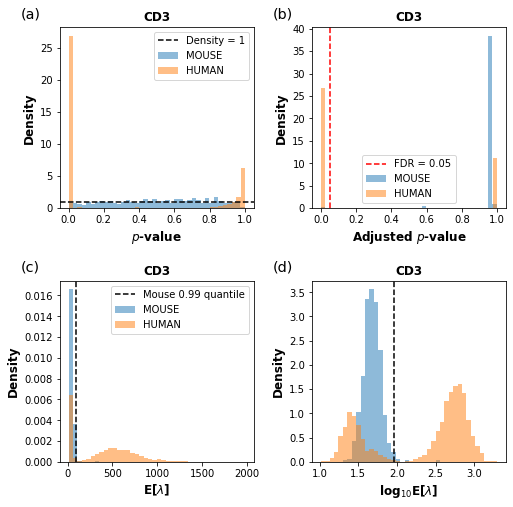

In [9]:
## generate figure from NB fitting
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(wspace=0.3, hspace=0.4)

fig.add_subplot(2,2,1)
plt.hist(pval0, bins=40, density=True, alpha = 0.5, label='MOUSE')
plt.hist(pval1, bins=40, density=True, alpha = 0.5, label='HUMAN')
plt.axhline(y=1., c='black', ls='--', label='Density = 1')
plt.xlabel('$\it{p}$-value', size='large', weight='bold')
plt.ylabel('Density', size='large', weight='bold')
plt.xlim([-0.05,1.05])
plt.legend()
plt.title(antigen, weight = 'bold')
plt.annotate('(a)', xy=(-0.2, 1.05), xycoords="axes fraction", size='x-large')

fig.add_subplot(2,2,2)
plt.hist(padj0, bins=40, density=True, alpha = 0.5, label='MOUSE')
plt.hist(padj1, bins=40, density=True, alpha = 0.5, label='HUMAN')
plt.axvline(x=0.05, c='red', ls='--', label='FDR = 0.05')

plt.xlabel('Adjusted $\it{p}$-value', size='large', weight='bold')
plt.ylabel('Density', size='large', weight='bold')
plt.xlim([-0.05,1.05])
plt.legend()
plt.title(antigen, weight = 'bold')
plt.annotate('(b)', xy=(-0.2, 1.05), xycoords="axes fraction", size='x-large')

fig.add_subplot(2,2,3)
ly0 = e_lam[df_ADT_label == 'MOUSE']
ly1 = e_lam[df_ADT_label != 'MOUSE']
hbins = np.linspace(e_lam.min(), e_lam.max(),40+1)
plt.hist(ly0, bins=hbins, density=True, alpha = 0.5, label='MOUSE')
plt.hist(ly1, bins=hbins, density=True, alpha = 0.5, label='HUMAN')
cutoff = np.quantile(ly0, 0.99)
plt.axvline(x=cutoff, c='black', ls='--', label='Mouse 0.99 quantile')
plt.xlabel('E[$\lambda$]', size='large', weight='bold')
plt.ylabel('Density', size='large', weight='bold')
plt.legend()
plt.title(antigen, weight = 'bold')
plt.annotate('(c)', xy=(-0.2, 1.05), xycoords="axes fraction", size='x-large')

fig.add_subplot(2,2,4)
ly0 = log_e_lam[df_ADT_label == 'MOUSE']
ly1 = log_e_lam[df_ADT_label != 'MOUSE']
hbins = np.linspace(log_e_lam.min(), log_e_lam.max(),40+1)
plt.hist(ly0, bins=hbins, density=True, alpha = 0.5, label='MOUSE')
plt.hist(ly1, bins=hbins, density=True, alpha = 0.5, label='HUMAN')
cutoff = np.quantile(ly0, 0.99)
plt.axvline(x=cutoff, c='black', ls='--', label='Mouse 0.99 quantile')
plt.xlabel('log${}_{10}$E[$\lambda$]', size='large', weight='bold')
plt.ylabel('Density', size='large', weight='bold')
plt.title(antigen, weight = 'bold')
plt.annotate('(d)', xy=(-0.2, 1.05), xycoords="axes fraction", size='x-large')

plt.show()
fig.savefig(path_figs+os.sep+'NB_fitting_'+'human_'+antigen+'.pdf', bbox_inches='tight')


Running the statistical methods over all the antigens measured, we can get a table of FDRs, as well as a table of transformed data. The scatter plots of the transformed data are suitable for visualization.

In [10]:
df_ADT_FDR_w_label = df_ADT_raw_w_label.copy()
df_ADT_transf_w_label = df_ADT_raw_w_label.copy()

## calculate the relative size factors
lg = np.mean(np.log(df_ADT_raw+1.), axis=1)
lg0 = lg[df_ADT_label == 'MOUSE']
lg00 = np.mean(lg0)
m = np.exp(lg - lg00)
m0 = m[df_ADT_label == 'MOUSE']
m1 = m[df_ADT_label != 'MOUSE']

for antigen in list_antigens_all:
    y = df_ADT_raw[antigen]
    y0 = y[df_ADT_label == 'MOUSE']
    y1 = y[df_ADT_label != 'MOUSE']
    ## model fitting, statitical tests, data transformation
    (a, b) = em_nb(y0, m0)
    pval0 = pval_nb(y0, m0, a, b)
    pval1 = pval_nb(y1, m1, a, b)
    padj0 = p_adjust_bh(pval0)
    padj1 = p_adjust_bh(pval1)
    log_e_lam = transf_zinb(y, m, a, b, w0=0., is_log='True', log_base=10)
    df_ADT_FDR_w_label.loc[df_ADT_label == 'MOUSE', antigen] = padj0
    df_ADT_FDR_w_label.loc[df_ADT_label != 'MOUSE', antigen] = padj1
    df_ADT_transf_w_label[antigen] = log_e_lam
    
## output the tables
df_ADT_FDR_w_label.to_csv(path_outs+os.path.sep+'human_CBMC_ADT_FDR_w_label'+'.csv')
df_ADT_transf_w_label.to_csv(path_outs+os.path.sep+'human_CBMC_ADT_transf_w_label'+'.csv')


In [11]:
df_ADT_FDR_w_label

,CD3,CD4,CD8,CD45RA,CD56,CD16,CD10,CD11c,CD14,CD19,CD34,CCR5,CCR7,transcriptomic_label
CTGTTTACACCGCTAG,0.956364,0.909443,0.917191,8.669299e-01,0.960984,0.987173,0.979172,0.966234,0.972287,9.085963e-01,0.982915,0.978609,0.992082,MOUSE
CTCTACGGTGTGGCTC,0.958069,0.981432,0.948352,9.363690e-09,0.960984,0.991714,0.996493,0.988803,0.999128,3.008704e-14,0.993632,0.978609,0.992082,MOUSE
AGCAGCCAGGCTCATT,0.956364,0.909443,0.928313,8.669299e-01,0.948842,0.987173,0.979172,0.966234,0.972287,9.085963e-01,0.988992,0.978609,0.992082,MOUSE
GAATAAGAGATCCCAT,0.956364,0.909443,0.917191,8.669299e-01,0.948842,0.987173,0.993002,0.966234,0.972287,9.085963e-01,0.982915,0.978609,0.992082,MOUSE
GTGCATAGTCATGCAT,0.956364,0.909443,0.917191,8.669299e-01,0.948842,0.987173,0.979172,0.966234,0.972287,9.085963e-01,0.982915,0.978609,0.992082,MOUSE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GGGAATGCAGTCAGCC,0.712647,0.823018,0.999994,8.220958e-01,0.168509,1.000000,1.000000,1.000000,1.000000,9.997375e-01,1.000000,1.000000,1.000000,Erythrocyte
TCGCGAGCAAGGACAC,0.608420,0.942999,0.241198,4.168740e-01,1.000000,1.000000,1.000000,1.000000,1.000000,9.997375e-01,1.000000,1.000000,1.000000,Erythrocyte
CCCATACAGTCTCGGC,0.999977,0.614552,0.999994,5.644492e-01,0.202974,1.000000,1.000000,1.000000,1.000000,9.997375e-01,1.000000,1.000000,1.000000,Erythrocyte
TGGTTCCGTCAAAGAT,0.028448,0.658815,0.999994,9.924389e-01,0.001810,1.000000,1.000000,0.041991,1.000000,3.883152e-01,1.000000,1.000000,1.000000,Erythrocyte


In [12]:
df_ADT_transf_w_label

,CD3,CD4,CD8,CD45RA,CD56,CD16,CD10,CD11c,CD14,CD19,CD34,CCR5,CCR7,transcriptomic_label
CTGTTTACACCGCTAG,1.610168,1.692007,1.706393,2.579088,1.661691,2.015035,1.998790,1.722487,2.113771,1.663683,2.055353,1.820055,1.820090,MOUSE
CTCTACGGTGTGGCTC,1.535003,1.532105,1.591760,3.385454,1.660535,1.854487,1.808577,1.651178,1.957849,2.554982,1.731613,1.805405,1.690079,MOUSE
AGCAGCCAGGCTCATT,1.790379,1.889859,1.655909,2.686543,1.789218,1.932134,1.913975,1.696295,2.076688,1.737474,1.779113,1.794334,1.763411,MOUSE
GAATAAGAGATCCCAT,1.745720,1.827706,1.760662,2.593455,1.778050,1.940828,1.867307,1.700344,2.117382,1.696202,1.934612,1.806467,1.720258,MOUSE
GTGCATAGTCATGCAT,1.607996,1.710800,1.766433,2.604971,1.805710,2.011726,1.913208,1.762244,2.027864,1.698327,1.972363,1.839130,1.754843,MOUSE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GGGAATGCAGTCAGCC,1.687319,1.773281,1.770941,2.446330,1.907536,1.931072,2.024537,1.680045,1.998548,1.679146,1.832618,1.846803,1.862081,Erythrocyte
TCGCGAGCAAGGACAC,1.711771,1.753646,1.905019,2.648283,1.636346,1.992949,1.959624,1.761515,2.015703,1.649994,1.933997,1.808312,1.767249,Erythrocyte
CCCATACAGTCTCGGC,1.578490,1.813455,1.783144,2.586250,1.884215,1.951842,2.020446,1.758293,2.022103,1.574729,1.833164,1.905714,1.749345,Erythrocyte
TGGTTCCGTCAAAGAT,1.935635,1.802288,1.831026,2.129973,2.042874,1.722202,1.839832,1.966337,1.998827,1.811192,1.874218,1.866159,1.673564,Erythrocyte


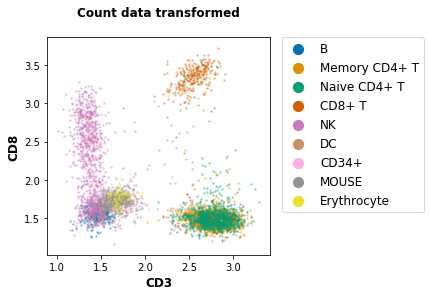

In [13]:
lx = 'CD3' # choose the antigen as the x-axis
ly = 'CD8' # choose the antigen as the y-axis

list_idents0 = ['B', 'Memory CD4+ T', 'Naive CD4+ T', 'CD8+ T', 
                'NK', 'DC', 'CD34+', 'MOUSE', 'Erythrocyte' ]
n_i = len(list_idents0)
colors = sns.color_palette("colorblind", n_i)

fig = plt.figure(figsize=(4,4))
for i in range(n_i):
    ident = list_idents0[i]
    plt.scatter( df_ADT_transf_w_label.loc[df_ADT_label == ident, lx], 
                 df_ADT_transf_w_label.loc[df_ADT_label == ident, ly], 
                 s=5, linewidths=0, alpha=0.5, color=colors[i], label=ident )
    
leg = plt.legend(bbox_to_anchor=(1.05, 1.), loc=2, borderaxespad=0., 
                 fontsize='large', markerscale=5)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(lx, size='large', weight='bold')
plt.ylabel(ly, size='large', weight='bold')
plt.title('Count data transformed\n', size='large', weight='bold')
plt.show()
fig.savefig(path_figs+os.sep+'Data_transformation_'+'human_CBMC_'+lx+'_vs_'+ly+'.pdf', bbox_inches='tight')


## Second example: mouse skin cell data set with 'spike-in' human cells, 6 samples


We now apply the geometric and statistical methods to our data set of mouse skin cells. There are 6 samples: OXA1, 2, 3 with treatment of inflammation-inducing oxazolone, and EtOH1,2,3 for control. We have selected the cells classified as mouse (with mouse RNA percentage >95%) and as human (with mouse RNA percentage <1%) using the scRNA-seq data. The single-cell ADT count data, labeled with the species and the sample IDs, is stored in `/data/mouse_skin_ADT_raw_w_label_6samples.csv`.

In [14]:
path_data = os.path.join( '..', 'data')
path_csv = os.path.join( path_data, 'mouse_skin_ADT_raw_w_label_6samples.csv')
df_ADT_raw_w_label_6samples = pd.read_csv(path_csv, index_col=None)
df_ADT_label = df_ADT_raw_w_label_6samples['Species']
df_ADT_sample = df_ADT_raw_w_label_6samples['Sample']
df_ADT_raw = df_ADT_raw_w_label_6samples.drop(columns=['Species','Sample'])
n_cells = len(df_ADT_raw_w_label_6samples)
total_count = np.sum(df_ADT_raw, axis=1)
list_samples = np.unique(df_ADT_sample)
n_samples = len(list_samples)
list_antigens_all = np.asarray(df_ADT_raw.columns)
list_antigens_print = ['CD3', 'CD4', 'CD8a', 'CD69', 'CD62L', 'CD44', 'CD25', 'CD127',
       'TCR γ/δ', 'CD19', 'IgM', 'CD335', 'NK-1.1', 'CD90.2', 'I-A/I-E',
       'CD45R', 'CD11b', 'CD172a', 'XCR1', 'CD103', 'CD64', 'CD11c',
       'CD24', 'CD326', 'CD195', 'CD196', 'CXCR4', 'CD134', 'CD278',
       'CD223', 'CD274', 'KLRG1', 'CD27', 'CD21/CD35', 'CD86', 'IgD',
       'CD1d', 'CD138', 'CD117', 'CX3CR1', 'F4/80', 'CD192'] # not good in file name

path_outs = os.path.join( '..', 'output')
if not os.path.exists(path_outs):
    os.makedirs(path_outs)
path_figs = path_outs
# path_figs = os.path.join( path_outs, 'figs' )
# if not os.path.exists(path_figs):
#     os.makedirs(path_figs)

In [15]:
df_ADT_raw_w_label_6samples

,CD3,CD4,CD8a,CD69,CD62L,CD44,CD25,CD127,TCRgd,CD19,...,CD86,IgD,CD1d,CD138,CD117,CX3CR1,F4-80,CD192,Species,Sample
0,1,0,1,1,1,100,0,2,7,3,...,3,4,1,1,1,1,1,0,HUMAN,EtOH1
1,1,1,0,0,1,15,0,0,4,0,...,2,2,0,0,1,2,2,0,HUMAN,EtOH1
2,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,HUMAN,EtOH1
3,0,0,2,0,2,31,1,0,2,0,...,3,2,1,0,0,0,1,0,HUMAN,EtOH1
4,1,1,0,3,1,49,0,0,0,2,...,4,3,1,0,0,1,2,0,HUMAN,EtOH1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33168,0,2,1,2,4,7,6,0,4,1,...,1,1,0,2,0,2,3,0,MOUSE,OXA3
33169,0,3,5,1,1,20,2,0,4,1,...,10,5,0,0,2,9,2,0,MOUSE,OXA3
33170,6,0,2,5,0,63,1,1,8,1,...,1,4,0,1,1,3,1,3,MOUSE,OXA3
33171,2,0,0,3,0,8,3,0,3,2,...,4,0,1,2,2,4,7,1,MOUSE,OXA3


### Computing Riemannian mean for each sample and removing batch correction


There are systematic biases among the 6 samples, and we build on the geometric methods to remove the batch effects, by aligning the Riemannian mean of the spiked-in human cells to a common point on the hypersphere.

We save the adjusted count data as `output/mouse_skin_ADT_adjusted_w_label_6samples'+'.csv`. We also use plots of [PCA (principal component analysis)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to demonstrate the batch effects and how they are removed after adjustment.

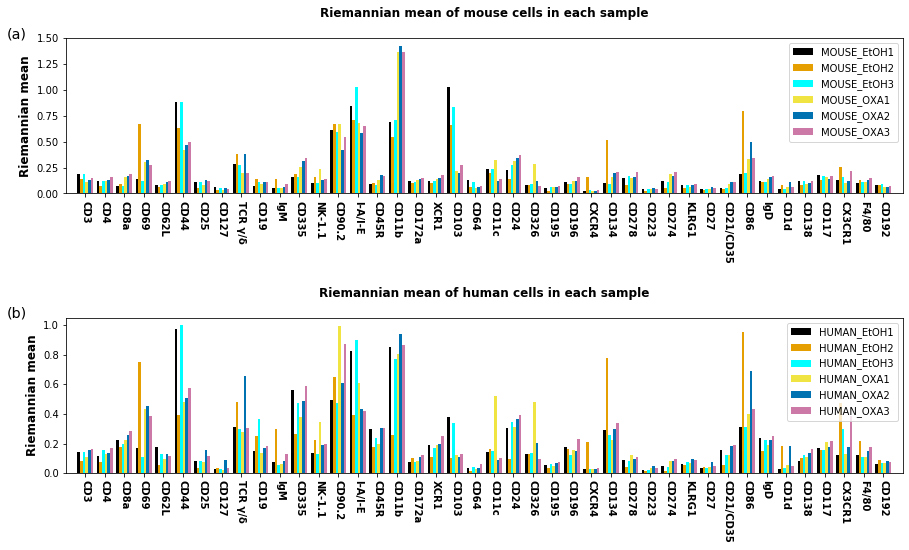

In [16]:
## plot the Riemannian mean for each sample

list_antigens_select = list_antigens_all
n_d = len(list_antigens_select)
list_idents0 = list_samples
n_i = len(list_idents0)
ls_colors = ["#000000", "#E69F00", "#00FFFF", "#F0E442", "#0072B2", "#CC79A7"]
colors = sns.color_palette(ls_colors)

fig = plt.figure(figsize=(15,8))
fig.subplots_adjust(hspace=0.8)

fig.add_subplot(211)
width = 0.95 / (n_i + 1)
for i in range(n_i):
    ident = list_idents0[i]
    df_ADT_subset = df_ADT_raw.loc[np.logical_and( df_ADT_label == 'MOUSE', 
                                  df_ADT_sample == ident )]
    count_data = df_ADT_subset[list_antigens_select].copy()
    plt.bar( np.arange(0,n_d)+width*(i-(n_i-1)/2), count2shpere_CoM(count_data), 
             width, label='MOUSE_'+ident, color=colors[i] )
    
plt.xticks(np.arange(0,n_d), list_antigens_print, rotation=-90, weight='bold')
plt.xlim(-1,n_d)
plt.legend()
# plt.legend(bbox_to_anchor=(1.01, 1.0), loc=2, borderaxespad=0.)
plt.ylabel('Riemannian mean', size='large', weight='bold')
plt.annotate('(a)', xy=(-0.07, 1.00), xycoords="axes fraction", size='x-large')
plt.title('Riemannian mean of mouse cells in each sample\n', weight='bold', fontsize='large')

fig.add_subplot(212)
width = 0.95 / (n_i + 1)
for i in range(n_i):
    ident = list_idents0[i]
    df_ADT_subset = df_ADT_raw.loc[np.logical_and( df_ADT_label == 'HUMAN', 
                                  df_ADT_sample == ident )]
    count_data = df_ADT_subset[list_antigens_select].copy()
    plt.bar( np.arange(0,n_d)+width*(i-(n_i-1)/2), count2shpere_CoM(count_data), 
             width, label='HUMAN_'+ident, color=colors[i] )
    
plt.xticks(np.arange(0,n_d), list_antigens_print, rotation=-90, weight='bold')
plt.xlim(-1,n_d)
plt.legend()
# plt.legend(bbox_to_anchor=(1.01, 1.0), loc=2, borderaxespad=0.)
plt.ylabel('Riemannian mean', size='large', weight='bold')
plt.annotate('(b)', xy=(-0.07, 1.00), xycoords="axes fraction", size='x-large')
plt.title('Riemannian mean of human cells in each sample\n', weight='bold', fontsize='large')

plt.show()
fig.savefig(path_figs+os.sep+'Riemannian_mean_of_'+'mouse_skin_6samples'+'.pdf', bbox_inches='tight')


In [17]:
## remove batch effects
# list_samples_excluded = ['EtOH2', 'OXA1', 'OXA2']
# see PCA plots before adjustment below why to exclude EtOH2, OXA1, OXA2
list_samples_combined = ['EtOH1', 'EtOH3', 'OXA3'] 
for i in range(len(list_samples_combined)):
    df_ADT_SpikeIn_i = df_ADT_raw.loc[np.logical_and( df_ADT_label == 'HUMAN', 
                                                      df_ADT_sample == list_samples_combined[i] )]
    if i == 0:
        df_ADT_SpikeIn_combined = df_ADT_SpikeIn_i.copy()
    else:
        df_ADT_SpikeIn_combined = df_ADT_SpikeIn_combined.append(df_ADT_SpikeIn_i.copy())

consensus_CoM = count2shpere_CoM(df_ADT_SpikeIn_combined)

df_ADT_on_hsphere = df_ADT_raw_w_label_6samples.copy()
df_ADT_on_simplex = df_ADT_raw_w_label_6samples.copy()
df_ADT_on_hsphere_adj = df_ADT_raw_w_label_6samples.copy()
df_ADT_on_simplex_adj = df_ADT_raw_w_label_6samples.copy()

for i in range(len(list_samples)):
    df_ADT_SpikeIn_i = df_ADT_raw.loc[np.logical_and( df_ADT_label == 'HUMAN', 
                                                      df_ADT_sample == list_samples[i] )]
    CoM_i = count2shpere_CoM(df_ADT_SpikeIn_i)
    df_ADT_raw_i = df_ADT_raw.loc[ df_ADT_sample == list_samples[i] ]
    df_ADT_label_i = df_ADT_label.loc[ df_ADT_sample == list_samples[i] ]
    count_data = df_ADT_raw_i.copy()

    ADT_on_hsphere_i = count2shpere(count_data)
    ADT_on_simplex_i = sphere2simplex(ADT_on_hsphere_i)
    ADT_on_hsphere_adj_i = RotateData_s(ADT_on_hsphere_i, CoM_i, consensus_CoM)
    ADT_on_simplex_adj_i = sphere2simplex(ADT_on_hsphere_adj_i)

    df_ADT_on_hsphere.loc[df_ADT_sample == list_samples[i], list_antigens_all] = ADT_on_hsphere_i
    df_ADT_on_simplex.loc[df_ADT_sample == list_samples[i], list_antigens_all] = ADT_on_simplex_i
    df_ADT_on_hsphere_adj.loc[df_ADT_sample == list_samples[i], list_antigens_all] = ADT_on_hsphere_adj_i
    df_ADT_on_simplex_adj.loc[df_ADT_sample == list_samples[i], list_antigens_all] = ADT_on_simplex_adj_i

df_ADT_adj = pd.DataFrame( data=np.rint( df_ADT_on_simplex_adj[list_antigens_all] 
                                        * total_count[:,None] ), dtype=int, columns=list_antigens_all)
## output the adjusted count data
df_ADT_adj.to_csv(path_outs+os.path.sep+'mouse_skin_ADT_adjusted_w_label_6samples'+'.csv')


In [18]:
df_ADT_adj

,CD3,CD4,CD8a,CD69,CD62L,CD44,CD25,CD127,TCRgd,CD19,...,CD27,CD21-CD35,CD86,IgD,CD1d,CD138,CD117,CX3CR1,F4-80,CD192
0,1,0,2,4,0,71,0,2,7,5,...,0,0,6,5,1,2,2,6,2,0
1,1,1,0,0,1,7,0,0,4,0,...,0,0,3,2,0,0,1,6,3,0
2,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2,0,0
3,0,0,3,0,1,20,1,0,2,0,...,0,1,5,2,1,0,0,1,1,0
4,1,2,0,6,1,34,0,0,0,3,...,0,0,6,3,1,0,0,4,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33168,0,2,1,1,4,11,6,0,4,1,...,0,1,1,1,0,2,0,1,3,0
33169,0,2,3,0,1,29,2,0,3,1,...,3,0,6,4,0,0,1,5,1,0
33170,6,0,1,3,0,72,1,1,7,1,...,0,2,0,4,0,1,1,2,1,3
33171,2,0,0,2,0,15,3,0,3,3,...,0,1,3,0,1,2,2,3,6,1


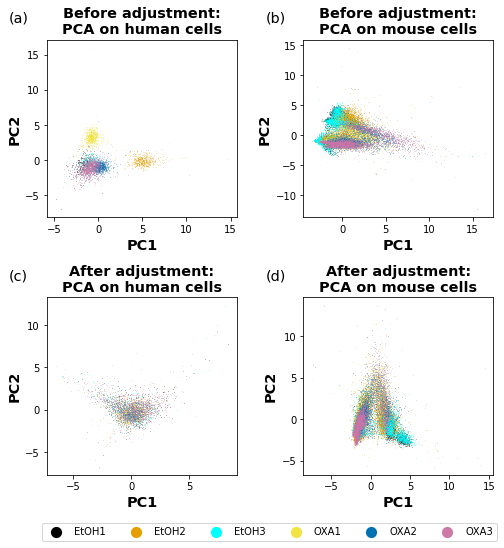

In [19]:
## PCA plots
import sklearn
from sklearn.decomposition import PCA
pca = PCA(n_components = 'mle', svd_solver = 'full')

ls_colors = ["#000000", "#E69F00", "#00FFFF", "#F0E442", "#0072B2", "#CC79A7"]
colors = sns.color_palette(ls_colors)

fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(wspace=0.35, hspace=0.45)

fig.add_subplot(221)
data = df_ADT_on_simplex[df_ADT_on_simplex['Species'] == 'HUMAN']
X = data.drop(columns=['Species', 'Sample'])
X_std = sklearn.preprocessing.scale(X)
pca.fit(X_std)
X_pca = pca.transform(X_std)

(lx, ly) = (1,2)
for i in range(n_samples):
    x = X_pca[data['Sample'] == list_samples[i]]
    plt.scatter(x[:,lx-1], x[:,ly-1], s=0.2, linewidths=0, 
                label=list_samples[i], color=colors[i] )
    
plt.xlabel('PC'+str(lx), size='x-large', weight = 'bold')
plt.ylabel('PC'+str(ly), size='x-large', weight = 'bold')
plt.title('Before adjustment:\nPCA on human cells', size='x-large', weight = 'bold')
plt.annotate('(a)', xy=(-0.2, 1.1), xycoords="axes fraction", size='x-large')

fig.add_subplot(222)
data = df_ADT_on_simplex[df_ADT_on_simplex['Species'] == 'MOUSE']
X = data.drop(columns=['Species', 'Sample'])
X_std = sklearn.preprocessing.scale(X)
pca.fit(X_std)
X_pca = pca.transform(X_std)

(lx, ly) = (1,2)
for i in range(n_samples):
    x = X_pca[data['Sample'] == list_samples[i]]
    plt.scatter(x[:,lx-1], x[:,ly-1], s=0.2, linewidths=0, 
                label=list_samples[i], color=colors[i] )
    
plt.xlabel('PC'+str(lx), size='x-large', weight = 'bold')
plt.ylabel('PC'+str(ly), size='x-large', weight = 'bold')
plt.title('Before adjustment:\nPCA on mouse cells', size='x-large', weight = 'bold')
plt.annotate('(b)', xy=(-0.2, 1.1), xycoords="axes fraction", size='x-large')

fig.add_subplot(223)
data = df_ADT_on_simplex_adj[df_ADT_on_simplex_adj['Species'] == 'HUMAN']
X = data.drop(columns=['Species', 'Sample'])
X_std = sklearn.preprocessing.scale(X)
pca.fit(X_std)
X_pca = pca.transform(X_std)

(lx, ly) = (1,2)
for i in range(n_samples):
    x = X_pca[data['Sample'] == list_samples[i]]
    plt.scatter(x[:,lx-1], x[:,ly-1], s=0.2, linewidths=0, 
                label=list_samples[i], color=colors[i] )
    
plt.xlabel('PC'+str(lx), size='x-large', weight = 'bold')
plt.ylabel('PC'+str(ly), size='x-large', weight = 'bold')
plt.title('After adjustment:\nPCA on human cells', size='x-large', weight = 'bold')
plt.annotate('(c)', xy=(-0.2, 1.1), xycoords="axes fraction", size='x-large')

fig.add_subplot(224)
data = df_ADT_on_simplex_adj[df_ADT_on_simplex_adj['Species'] == 'MOUSE']
X = data.drop(columns=['Species', 'Sample'])
X_std = sklearn.preprocessing.scale(X)
pca.fit(X_std)
X_pca = pca.transform(X_std)

(lx, ly) = (1,2)
for i in range(n_samples):
    x = X_pca[data['Sample'] == list_samples[i]]
    plt.scatter(x[:,lx-1], x[:,ly-1], s=0.2, linewidths=0, 
                label=list_samples[i], color=colors[i] )
    
plt.xlabel('PC'+str(lx), size='x-large', weight = 'bold')
plt.ylabel('PC'+str(ly), size='x-large', weight = 'bold')
plt.title('After adjustment:\nPCA on mouse cells', size='x-large', weight = 'bold')
plt.annotate('(d)', xy=(-0.2, 1.1), xycoords="axes fraction", size='x-large')

plt.legend(loc=3, bbox_to_anchor=(-1.4, -0.4), markerscale=25, ncol=6)
plt.show()
fig.savefig(path_figs+os.path.sep+'PCA_before_and_after_adj_'+'mouse_skin_6samples''.pdf', bbox_inches='tight')


###  NB or ZINB fitting and statistical tests


Finally, with the adjusted count data after batch correction, we can fit a NB (negative binomial) or ZINB(zero-inflated negative binomial) model on the human cells to build the null model, perform statistical tests, and transform the count data with the fitted model parameters.

We fit a NB model for the highly expressed antigen I-A/I-E, and a ZINB model for the lowly expressed antigen CD4 in the data set.

In [20]:
## calculate the relative size factors
lg = np.mean(np.log(df_ADT_adj+1.), axis=1)
lg0 = lg[df_ADT_label == 'HUMAN']
lg00 = np.mean(lg0)
m = np.exp(lg - lg00)
m0 = m[df_ADT_label == 'HUMAN']
m1 = m[df_ADT_label == 'MOUSE']

## choose an antigen
antigen = 'I-A-I-E'
y = df_ADT_adj[antigen]
y0 = y[df_ADT_label == 'HUMAN']
y1 = y[df_ADT_label == 'MOUSE']

(a, b) = em_nb(y0, m0)
pval0 = pval_nb(y0, m0, a, b)
pval1 = pval_nb(y1, m1, a, b)
padj0 = p_adjust_bh(pval0)
padj1 = p_adjust_bh(pval1)
e_lam = transf_zinb(y, m, a, b, w0=0., is_log='False')
log_e_lam = transf_zinb(y, m, a, b, w0=0., is_log='True', log_base=10)

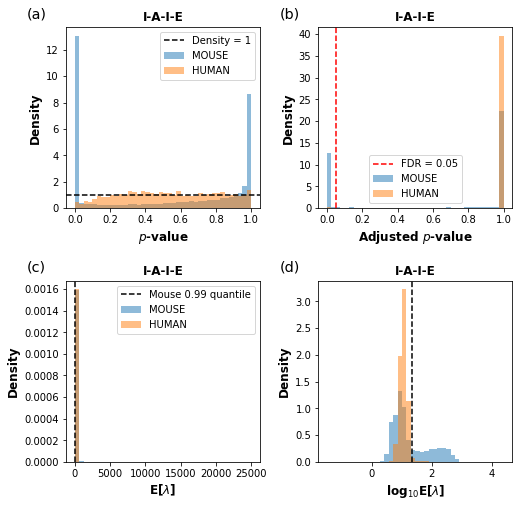

In [21]:
## generate figure from NB fitting
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(wspace=0.3, hspace=0.4)

fig.add_subplot(2,2,1)
plt.hist(pval1, bins=40, density=True, alpha = 0.5, label='MOUSE')
plt.hist(pval0, bins=40, density=True, alpha = 0.5, label='HUMAN')
plt.axhline(y=1., c='black', ls='--', label='Density = 1')
plt.xlabel('$\it{p}$-value', size='large', weight='bold')
plt.ylabel('Density', size='large', weight='bold')
plt.xlim([-0.05,1.05])
plt.legend()
plt.title(antigen, weight = 'bold')
plt.annotate('(a)', xy=(-0.2, 1.05), xycoords="axes fraction", size='x-large')

fig.add_subplot(2,2,2)
plt.hist(padj1, bins=40, density=True, alpha = 0.5, label='MOUSE')
plt.hist(padj0, bins=40, density=True, alpha = 0.5, label='HUMAN')
plt.axvline(x=0.05, c='red', ls='--', label='FDR = 0.05')

plt.xlabel('Adjusted $\it{p}$-value', size='large', weight='bold')
plt.ylabel('Density', size='large', weight='bold')
plt.xlim([-0.05,1.05])
plt.legend()
plt.title(antigen, weight = 'bold')
plt.annotate('(b)', xy=(-0.2, 1.05), xycoords="axes fraction", size='x-large')

fig.add_subplot(2,2,3)
ly1 = e_lam[df_ADT_label == 'MOUSE']
ly0 = e_lam[df_ADT_label == 'HUMAN']
hbins = np.linspace(e_lam.min(), e_lam.max(),40+1)
plt.hist(ly1, bins=hbins, density=True, alpha = 0.5, label='MOUSE')
plt.hist(ly0, bins=hbins, density=True, alpha = 0.5, label='HUMAN')
cutoff = np.quantile(ly0, 0.99)
plt.axvline(x=cutoff, c='black', ls='--', label='Mouse 0.99 quantile')
plt.xlabel('E[$\lambda$]', size='large', weight='bold')
plt.ylabel('Density', size='large', weight='bold')
plt.legend()
plt.title(antigen, weight = 'bold')
plt.annotate('(c)', xy=(-0.2, 1.05), xycoords="axes fraction", size='x-large')

fig.add_subplot(2,2,4)
ly1 = log_e_lam[df_ADT_label == 'MOUSE']
ly0 = log_e_lam[df_ADT_label != 'MOUSE']
hbins = np.linspace(log_e_lam.min(), log_e_lam.max(),40+1)
plt.hist(ly1, bins=hbins, density=True, alpha = 0.5, label='MOUSE')
plt.hist(ly0, bins=hbins, density=True, alpha = 0.5, label='HUMAN')
cutoff = np.quantile(ly0, 0.99)
plt.axvline(x=cutoff, c='black', ls='--', label='Mouse 0.99 quantile')
plt.xlabel('log${}_{10}$E[$\lambda$]', size='large', weight='bold')
plt.ylabel('Density', size='large', weight='bold')
plt.title(antigen, weight = 'bold')
plt.annotate('(d)', xy=(-0.2, 1.05), xycoords="axes fraction", size='x-large')

plt.show()
fig.savefig(path_figs+os.sep+'NB_fitting_'+'mouse_'+antigen+'.pdf', bbox_inches='tight')


In [22]:
## calculate the relative size factors
lg = np.mean(np.log(df_ADT_adj+1.), axis=1)
lg0 = lg[df_ADT_label == 'HUMAN']
lg00 = np.mean(lg0)
m = np.exp(lg - lg00)
m0 = m[df_ADT_label == 'HUMAN']
m1 = m[df_ADT_label == 'MOUSE']

## choose an antigen
antigen = 'CD4'
y = df_ADT_adj[antigen]
y0 = y[df_ADT_label == 'HUMAN']
y1 = y[df_ADT_label == 'MOUSE']

(w0, a, b, is_conv) = em_zinb(y0, m0)
pval0 = pval_zinb(y0, m0, w0, a, b)
pval1 = pval_zinb(y1, m1, w0, a, b)
padj0 = p_adjust_bh(pval0)
padj1 = p_adjust_bh(pval1)
e_lam = transf_zinb(y, m, a, b, w0, is_log='False')
log_e_lam = transf_zinb(y, m, a, b, w0, is_log='True', log_base=10)

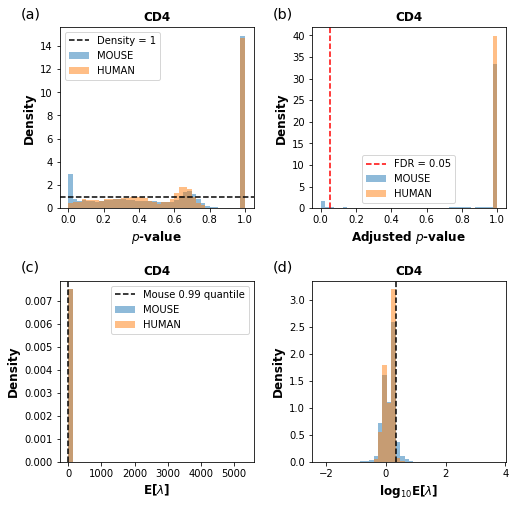

In [23]:
## generate figure from ZINB fitting
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(wspace=0.3, hspace=0.4)

fig.add_subplot(2,2,1)
plt.hist(pval1, bins=40, density=True, alpha = 0.5, label='MOUSE')
plt.hist(pval0, bins=40, density=True, alpha = 0.5, label='HUMAN')
plt.axhline(y=1., c='black', ls='--', label='Density = 1')
plt.xlabel('$\it{p}$-value', size='large', weight='bold')
plt.ylabel('Density', size='large', weight='bold')
plt.xlim([-0.05,1.05])
plt.legend()
plt.title(antigen, weight = 'bold')
plt.annotate('(a)', xy=(-0.2, 1.05), xycoords="axes fraction", size='x-large')

fig.add_subplot(2,2,2)
plt.hist(padj1, bins=40, density=True, alpha = 0.5, label='MOUSE')
plt.hist(padj0, bins=40, density=True, alpha = 0.5, label='HUMAN')
plt.axvline(x=0.05, c='red', ls='--', label='FDR = 0.05')

plt.xlabel('Adjusted $\it{p}$-value', size='large', weight='bold')
plt.ylabel('Density', size='large', weight='bold')
plt.xlim([-0.05,1.05])
plt.legend()
plt.title(antigen, weight = 'bold')
plt.annotate('(b)', xy=(-0.2, 1.05), xycoords="axes fraction", size='x-large')

fig.add_subplot(2,2,3)
ly1 = e_lam[df_ADT_label == 'MOUSE']
ly0 = e_lam[df_ADT_label == 'HUMAN']
hbins = np.linspace(e_lam.min(), e_lam.max(),40+1)
plt.hist(ly1, bins=hbins, density=True, alpha = 0.5, label='MOUSE')
plt.hist(ly0, bins=hbins, density=True, alpha = 0.5, label='HUMAN')
cutoff = np.quantile(ly0, 0.99)
plt.axvline(x=cutoff, c='black', ls='--', label='Mouse 0.99 quantile')
plt.xlabel('E[$\lambda$]', size='large', weight='bold')
plt.ylabel('Density', size='large', weight='bold')
plt.legend()
plt.title(antigen, weight = 'bold')
plt.annotate('(c)', xy=(-0.2, 1.05), xycoords="axes fraction", size='x-large')

fig.add_subplot(2,2,4)
ly1 = log_e_lam[df_ADT_label == 'MOUSE']
ly0 = log_e_lam[df_ADT_label != 'MOUSE']
hbins = np.linspace(log_e_lam.min(), log_e_lam.max(),40+1)
plt.hist(ly1, bins=hbins, density=True, alpha = 0.5, label='MOUSE')
plt.hist(ly0, bins=hbins, density=True, alpha = 0.5, label='HUMAN')
cutoff = np.quantile(ly0, 0.99)
plt.axvline(x=cutoff, c='black', ls='--', label='Mouse 0.99 quantile')
plt.xlabel('log${}_{10}$E[$\lambda$]', size='large', weight='bold')
plt.ylabel('Density', size='large', weight='bold')
plt.title(antigen, weight = 'bold')
plt.annotate('(d)', xy=(-0.2, 1.05), xycoords="axes fraction", size='x-large')

plt.show()
fig.savefig(path_figs+os.sep+'ZINB_fitting_'+'mouse_'+antigen+'.pdf', bbox_inches='tight')
